# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_173  Q14894           15.079
Sample_093  P13521           20.355
Sample_177  P61769           24.240
Sample_111  P04180           17.513
Sample_036  Q9UHF0           16.559
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups      
Sample_204  F5H423;P61204;P84077   12.990
Sample_014  P12955                 14.026
Sample_162  G3V3A0                 17.381
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.475
            A0A075B6Q5                 12.612
            A0A075B6R2                 12.233
            A0A075B6S5                 11.482
            A0A087WSY4                 14.011
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.969
            Q9UI40;Q9UI40-2            13.241
            Q9UIW2                     13.056
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.138
            Q9UP79                     12.521
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.976,15.050,16.842,19.863,16.192,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.624,19.067,...,15.528,15.576,14.228,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.934,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.657,17.705,17.039,15.847,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.782,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.721,15.345,17.084,18.708,14.249,19.433,11.521,10.758
Sample_207,15.739,16.877,15.469,16.898,13.202,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.475,...,16.012,15.178,13.321,15.050,16.842,19.863,12.263,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.157,19.067,16.188,...,15.528,15.576,12.623,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.264,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.504,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.164,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.533,15.345,17.084,18.708,14.249,19.433,11.112,13.013
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 388.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.63it/s]

100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.44it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.50it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.14it/s]

100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.26it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.52it/s]

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.18it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.35it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.77it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.54it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.46it/s]

100%|██████████| 7/7 [00:01<00:00,  3.29it/s]

100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.18it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.31it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.95it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.15it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.53it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.31it/s]

100%|██████████| 8/8 [00:02<00:00,  2.16it/s]

100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.03it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.01it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.76it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.74it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.71it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.86it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.94it/s]

100%|██████████| 9/9 [00:03<00:00,  3.03it/s]

100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.69it/s]

 30%|███       | 3/10 [00:00<00:02,  3.33it/s]

 40%|████      | 4/10 [00:01<00:01,  3.38it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.64it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.52it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.39it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.23it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.29it/s]

100%|██████████| 10/10 [00:02<00:00,  3.23it/s]

100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.73it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.33it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.94it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.85it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.65it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.52it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.46it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.50it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.47it/s]

100%|██████████| 11/11 [00:03<00:00,  2.72it/s]

100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.17it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.53it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.86it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.56it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.23it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.73it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.41it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.33it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.18it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.39it/s]

100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

100%|██████████| 12/12 [00:04<00:00,  2.76it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.53it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.60it/s]

 31%|███       | 4/13 [00:01<00:02,  3.03it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.62it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.37it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.25it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.31it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.38it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.44it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.57it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.61it/s]

100%|██████████| 13/13 [00:05<00:00,  2.52it/s]

100%|██████████| 13/13 [00:05<00:00,  2.59it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.45it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.47it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.07it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.09it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.17it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.26it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.39it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.51it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.54it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.54it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.57it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.59it/s]

100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

100%|██████████| 14/14 [00:05<00:00,  2.45it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.44it/s]

 20%|██        | 3/15 [00:00<00:03,  3.28it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.85it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.87it/s]

 40%|████      | 6/15 [00:01<00:03,  2.88it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.82it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.74it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.81it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.74it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.73it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.87it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.76it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.52it/s]

100%|██████████| 15/15 [00:05<00:00,  2.43it/s]

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.070 0.029          0.671 0.414       0.088   
2             0.006 0.005      0.073 0.035          0.805 0.078       0.709   
3             0.006 0.006      0.080 0.030          0.812 0.082       0.730   
4             0.005 0.004      0.066 0.024          0.835 0.083       0.771   
5             0.005 0.003      0.073 0.032          0.830 0.087       0.757   
6             0.007 0.006      0.079 0.030          0.813 0.082       0.747   
7             0.007 0.005      0.082 0.029          0.799 0.088       0.750   
8             0.005 0.004      0.061 0.022          0.806 0.093       0.750   
9             0.004 0.002      0.061 0.021          0.815 0.076       0.814   
10            0.006 0.004      0.086 0.039          0.827 0.084       0.817   
11            0.007 0.006      0.086 0.034          0.823 0.080       0.811   
12            0.006 0.005      0.072 0.031          0.842 0.066       0.837   
13            0.006 0.004      0.067 0.027          0.826 0.076       0.836   
14            0.007 0.005      0.075 0.026          0.823 0.076       0.835   
15            0.005 0.004      0.063 0.023          0.807 0.078       0.828   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.150 0.123                  0.537 0.038        0.854   
2          0.120   0.748 0.085                  0.791 0.063        0.866   
3          0.121   0.763 0.085                  0.803 0.064        0.870   
4          0.118   0.798 0.087                  0.830 0.070        0.886   
5          0.115   0.788 0.088                  0.822 0.070        0.885   
6          0.125   0.774 0.091                  0.811 0.070        0.881   
7          0.123   0.768 0.089                  0.805 0.070        0.886   
8          0.116   0.773 0.090                  0.808 0.072        0.886   
9          0.119   0.809 0.075                  0.838 0.062        0.907   
10         0.114   0.816 0.073                  0.844 0.060        0.909   
11         0.118   0.811 0.075                  0.840 0.061        0.909   
12         0.105   0.835 0.063                  0.860 0.054        0.915   
13         0.103   0.827 0.071                  0.853 0.061        0.914   
14         0.102   0.825 0.069                  0.851 0.059        0.912   
15         0.106   0.813 0.071                  0.840 0.061        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.821 0.085        210.000 0.000  
2          0.062                  0.850 0.074        210.000 0.000  
3          0.058                  0.852 0.067        210.000 0.000  
4          0.063                  0.880 0.063        210.000 0.000  
5          0.062                  0.878 0.064        210.000 0.000  
6          0.061                  0.871 0.066        210.000 0.000  
7          0.060                  0.876 0.065        210.000 0.000  
8          0.058                  0.876 0.065        210.000 0.000  
9          0.050                  0.890 0.054        210.000 0.000  
10         0.048                  0.889 0.056        210.000 0.000  
11         0.049                  0.889 0.057        210.000 0.000  
12         0.047                  0.900 0.053        210.000 0.000  
13         0.048                  0.899 0.053        210.000 0.000  
14         0.049                  0.897 0.053        210.000 0.000  
15         0.048                  0.893 0.053 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 329.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.10it/s]

100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.93it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.07it/s]

100%|██████████| 4/4 [00:01<00:00,  1.88it/s]

100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.72it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.44it/s]

100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.56it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.33it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.26it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.03it/s]

100%|██████████| 6/6 [00:02<00:00,  1.79it/s]

100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.65it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.70it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.50it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.04it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.91it/s]

100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.47it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.77it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.42it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.11it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.47it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.09it/s]

100%|██████████| 8/8 [00:03<00:00,  1.75it/s]

100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.45it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.72it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.28it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.02it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.75it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.16it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.98it/s]

100%|██████████| 9/9 [00:03<00:00,  1.88it/s]

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.56it/s]

 30%|███       | 3/10 [00:00<00:01,  4.00it/s]

 40%|████      | 4/10 [00:01<00:01,  3.49it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.21it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.76it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.21it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.10it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.95it/s]

100%|██████████| 10/10 [00:04<00:00,  1.93it/s]

100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.46it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.65it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.19it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.07it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.69it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.66it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.37it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.28it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.19it/s]

100%|██████████| 11/11 [00:04<00:00,  2.11it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.39it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.85it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.06it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.78it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.78it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.66it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.70it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.31it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.08it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.91it/s]

100%|██████████| 12/12 [00:04<00:00,  2.02it/s]

100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.74it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.81it/s]

 31%|███       | 4/13 [00:01<00:02,  3.15it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.91it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.65it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.67it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.70it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.27it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.08it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.03it/s]

100%|██████████| 13/13 [00:05<00:00,  2.05it/s]

100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.99it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.36it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.84it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.67it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.72it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.62it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.65it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.68it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.26it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.13it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.00it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.89it/s]

100%|██████████| 14/14 [00:05<00:00,  2.06it/s]

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.69it/s]

 20%|██        | 3/15 [00:00<00:03,  3.55it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.17it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.99it/s]

 40%|████      | 6/15 [00:01<00:03,  2.89it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.87it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.39it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.19it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.05it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.94it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.76it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.77it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.76it/s]

100%|██████████| 15/15 [00:06<00:00,  1.91it/s]

100%|██████████| 15/15 [00:06<00:00,  2.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.067 0.029          0.208 0.369       0.023   
2             0.006 0.004      0.070 0.026          0.751 0.126       0.645   
3             0.005 0.004      0.056 0.018          0.773 0.091       0.716   
4             0.005 0.004      0.059 0.018          0.740 0.094       0.657   
5             0.006 0.004      0.070 0.029          0.758 0.096       0.700   
6             0.005 0.004      0.056 0.018          0.754 0.090       0.701   
7             0.005 0.005      0.068 0.026          0.759 0.102       0.721   
8             0.005 0.004      0.058 0.021          0.759 0.101       0.721   
9             0.005 0.003      0.065 0.024          0.784 0.095       0.766   
10            0.005 0.004      0.058 0.020          0.776 0.091       0.769   
11            0.006 0.004      0.065 0.022          0.789 0.089       0.792   
12            0.005 0.004      0.059 0.022          0.799 0.089       0.793   
13            0.006 0.005      0.063 0.022          0.798 0.090       0.790   
14            0.006 0.005      0.059 0.021          0.791 0.089       0.792   
15            0.006 0.004      0.066 0.024          0.803 0.088       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.049   0.040 0.080                  0.507 0.021        0.872   
2          0.125   0.684 0.096                  0.738 0.075        0.803   
3          0.107   0.739 0.080                  0.780 0.064        0.865   
4          0.127   0.689 0.094                  0.743 0.071        0.873   
5          0.134   0.721 0.093                  0.767 0.074        0.881   
6          0.133   0.720 0.090                  0.765 0.071        0.880   
7          0.130   0.734 0.098                  0.776 0.080        0.884   
8          0.129   0.734 0.096                  0.776 0.078        0.881   
9          0.122   0.770 0.091                  0.805 0.076        0.896   
10         0.114   0.768 0.086                  0.802 0.072        0.898   
11         0.114   0.787 0.085                  0.818 0.072        0.921   
12         0.117   0.791 0.086                  0.823 0.071        0.922   
13         0.118   0.790 0.086                  0.821 0.073        0.921   
14         0.117   0.786 0.084                  0.818 0.070        0.921   
15         0.106   0.793 0.076                  0.823 0.063        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.837 0.086        210.000 0.000  
2          0.071                  0.742 0.094        210.000 0.000  
3          0.057                  0.830 0.072        210.000 0.000  
4          0.055                  0.839 0.065        210.000 0.000  
5          0.052                  0.848 0.068        210.000 0.000  
6          0.052                  0.849 0.063        210.000 0.000  
7          0.055                  0.852 0.067        210.000 0.000  
8          0.056                  0.849 0.068        210.000 0.000  
9          0.054                  0.873 0.065        210.000 0.000  
10         0.052                  0.877 0.061        210.000 0.000  
11         0.045                  0.902 0.051        210.000 0.000  
12         0.045                  0.904 0.052        210.000 0.000  
13         0.045                  0.903 0.052        210.000 0.000  
14         0.045                  0.899 0.055        210.000 0.000  
15         0.043                  0.903 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.36it/s]

100%|██████████| 3/3 [00:00<00:00, 14.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 15.00it/s]

100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.44it/s]

100%|██████████| 5/5 [00:00<00:00, 14.03it/s]

100%|██████████| 5/5 [00:00<00:00, 14.43it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.96it/s]

100%|██████████| 6/6 [00:00<00:00, 17.19it/s]

100%|██████████| 6/6 [00:00<00:00, 17.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.32it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.37it/s]

100%|██████████| 7/7 [00:00<00:00, 11.77it/s]

100%|██████████| 7/7 [00:00<00:00, 12.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.99it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.32it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 14.16it/s]

100%|██████████| 8/8 [00:00<00:00, 12.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.14it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.82it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.84it/s]

100%|██████████| 9/9 [00:00<00:00, 13.49it/s]

100%|██████████| 9/9 [00:00<00:00, 14.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.43it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.19it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.05it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.66it/s]

100%|██████████| 10/10 [00:00<00:00, 11.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 16.40it/s]

 36%|███▋      | 4/11 [00:00<00:00, 10.73it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.73it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.34it/s]

 91%|█████████ | 10/11 [00:01<00:00,  9.35it/s]

100%|██████████| 11/11 [00:01<00:00,  9.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.72it/s]

 33%|███▎      | 4/12 [00:00<00:00, 13.59it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.97it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.06it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  7.90it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  7.51it/s]

100%|██████████| 12/12 [00:01<00:00,  7.73it/s]

100%|██████████| 12/12 [00:01<00:00,  8.62it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.57it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.27it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.40it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.32it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.78it/s]

100%|██████████| 13/13 [00:01<00:00, 12.66it/s]

100%|██████████| 13/13 [00:01<00:00, 12.79it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 13.52it/s]

 36%|███▌      | 5/14 [00:00<00:00,  9.95it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.52it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.42it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.49it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.97it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.90it/s]

100%|██████████| 14/14 [00:01<00:00, 10.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.04it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.11it/s]

 40%|████      | 6/15 [00:00<00:00, 10.38it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.73it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.22it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.91it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.80it/s]

100%|██████████| 15/15 [00:01<00:00, 11.52it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.076 0.031          0.000 0.000       0.000   
2             0.006 0.005      0.085 0.046          0.620 0.100       0.500   
3             0.004 0.002      0.061 0.020          0.666 0.101       0.560   
4             0.004 0.002      0.054 0.017          0.682 0.084       0.614   
5             0.005 0.004      0.062 0.030          0.703 0.077       0.659   
6             0.006 0.004      0.057 0.018          0.699 0.078       0.632   
7             0.004 0.002      0.050 0.013          0.718 0.081       0.664   
8             0.005 0.003      0.065 0.024          0.726 0.072       0.690   
9             0.007 0.009      0.076 0.033          0.721 0.071       0.684   
10            0.005 0.004      0.053 0.012          0.710 0.070       0.715   
11            0.007 0.005      0.063 0.021          0.717 0.067       0.714   
12            0.005 0.005      0.058 0.023          0.719 0.085       0.726   
13            0.009 0.007      0.083 0.032          0.700 0.077       0.709   
14            0.006 0.005      0.073 0.029          0.695 0.073       0.720   
15            0.007 0.006      0.080 0.031          0.683 0.069       0.716   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.758   
2          0.105   0.547 0.086                  0.636 0.062        0.746   
3          0.108   0.601 0.082                  0.674 0.061        0.767   
4          0.108   0.641 0.082                  0.701 0.061        0.801   
5          0.120   0.675 0.086                  0.728 0.064        0.807   
6          0.116   0.657 0.084                  0.715 0.059        0.819   
7          0.106   0.683 0.078                  0.734 0.058        0.825   
8          0.111   0.702 0.075                  0.748 0.058        0.844   
9          0.110   0.697 0.075                  0.744 0.058        0.839   
10         0.109   0.707 0.070                  0.749 0.056        0.840   
11         0.110   0.710 0.071                  0.753 0.057        0.837   
12         0.117   0.717 0.087                  0.758 0.070        0.847   
13         0.119   0.699 0.084                  0.743 0.066        0.841   
14         0.135   0.700 0.089                  0.744 0.068        0.844   
15         0.140   0.692 0.092                  0.737 0.069        0.839   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.703 0.084        210.000 0.000  
2          0.062                  0.671 0.085        210.000 0.000  
3          0.065                  0.692 0.092        210.000 0.000  
4          0.058                  0.732 0.082        210.000 0.000  
5          0.058                  0.723 0.085        210.000 0.000  
6          0.060                  0.739 0.087        210.000 0.000  
7          0.057                  0.740 0.089        210.000 0.000  
8          0.053                  0.780 0.068        210.000 0.000  
9          0.053                  0.774 0.068        210.000 0.000  
10         0.056                  0.781 0.072        210.000 0.000  
11         0.056                  0.774 0.077        210.000 0.000  
12         0.058                  0.783 0.077        210.000 0.000  
13         0.059                  0.777 0.079        210.000 0.000  
14         0.057                  0.778 0.078        210.000 0.000  
15         0.057                  0.773 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,13,13
score_time,11,5,2
test_precision,12,15,8
test_recall,12,15,12
test_f1,12,15,12
test_balanced_accuracy,12,15,12
test_roc_auc,12,15,12
test_average_precision,12,12,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.18it/s]

 20%|██        | 3/15 [00:00<00:04,  2.85it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.09it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.90it/s]

 40%|████      | 6/15 [00:02<00:04,  1.93it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.76it/s]

 53%|█████▎    | 8/15 [00:04<00:04,  1.70it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.67it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  1.83it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.67it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.61it/s]

 87%|████████▋ | 13/15 [00:07<00:01,  1.54it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.46it/s]

100%|██████████| 15/15 [00:08<00:00,  1.62it/s]

100%|██████████| 15/15 [00:08<00:00,  1.77it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.12it/s]

 33%|███▎      | 4/12 [00:00<00:00, 14.55it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.57it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 12.07it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 11.52it/s]

100%|██████████| 12/12 [00:01<00:00, 11.54it/s]

100%|██████████| 12/12 [00:01<00:00, 11.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.11it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.73it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.04it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.58it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.51it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.55it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.62it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.37it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.23it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.04it/s]

100%|██████████| 12/12 [00:04<00:00,  2.07it/s]

100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


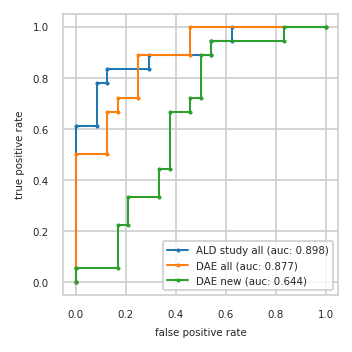

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.611   0.000 0.500   0.167 0.056
3          0.083 0.611   0.125 0.500   0.167 0.222
4          0.083 0.778   0.125 0.667   0.208 0.222
5          0.125 0.778   0.167 0.667   0.208 0.333
6          0.125 0.833   0.167 0.722   0.333 0.333
7          0.292 0.833   0.250 0.722   0.333 0.444
8          0.292 0.889   0.250 0.889   0.375 0.444
9          0.542 0.889   0.458 0.889   0.375 0.667
10         0.542 0.944   0.458 1.000   0.458 0.667
11         0.625 0.944   1.000 1.000   0.458 0.722
12         0.625 1.000     NaN   NaN   0.500 0.722
13         1.000 1.000     NaN   NaN   0.500 0.889
14           NaN   NaN     NaN   NaN   0.542 0.889
15           NaN   NaN     NaN   NaN   0.542 0.944
16           NaN   NaN     NaN   NaN   0.833 0.944
17           NaN   NaN     NaN   NaN   0.833 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NBI6,P02766,B1AJQ6;Q86Y82
2,Q16674;W4VSR3,P01704,A0A0A0MSQ0;P13797;P13797-2;P13797-3
3,P61981,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,P14174,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,Q14894,P51688
6,Q9Y2T3;Q9Y2T3-3,P51688,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
7,P00338;P00338-3,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P63104,P14174,O95497


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


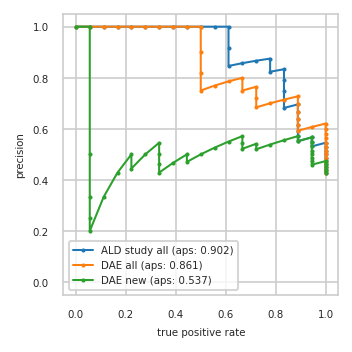

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.567 0.944
13         0.552 0.889     0.621 1.000     0.552 0.889
14         0.571 0.889     0.607 0.944     0.571 0.889
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.696 0.889     0.522 0.667
20         0.682 0.833     0.727 0.889     0.545 0.667
21         0.714 0.833     0.714 0.833     0.571 0.667
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.684 0.722     0.526 0.556
24         0.833 0.833     0.722 0.722     0.500 0.500
25         0.824 0.778     0.765 0.722     0.471 0.444
26         0.875 0.778     0.750 0.667     0.500 0.444
27         0.867 0.722     0.800 0.667     0.467 0.389
28         0.857 0.667     0.786 0.611     0.429 0.333
29         0.846 0.611     0.769 0.556     0.462 0.333
30         0.917 0.611     0.750 0.500     0.500 0.333
31         1.000 0.611     0.818 0.500     0.545 0.333
32         1.000 0.556     0.900 0.500     0.500 0.278
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.200 0.056
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


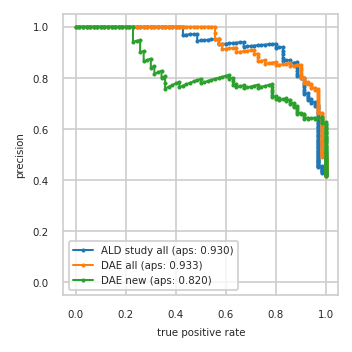

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


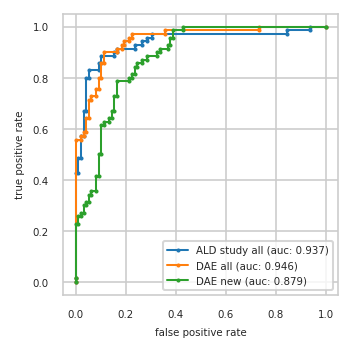

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}